NRES Signal to  trend analysis
---

Plot normalized signal to noise as repoprted by NRES pipeline.

Input: a number of input files containing the signal to noise for starts:

   Format:
   STAR_NAME  Vmag  SN   Texp
       
Code will calculate the S/N normalized to a 60 sec exposure. However, this calculation assumes that 
exposurs remain shot noise dominated in this process, i.e., this calculation is somewhat off. 



In [1]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
plt.rcParams["figure.figsize"] = (10,6)
from matplotlib import style
plt.style.use('ggplot')

In [2]:

def readdata (fname):
    
    data = np.genfromtxt (fname, unpack=True, dtype=None, 
                          skip_footer=0, names=['star','vmag','sn','texp'])
    sn60 = data['sn'] * np.sqrt (60. / data['texp'])
    return data['vmag'], sn60


def snmodel (s0=180000, ron=5):
    x = np.arange (2,10,0.5)
    s = 10 ** (-0.4 * x) * s0
    sn = s / np.sqrt (s + 3 * ron ** 2)
    return x, sn


def plotfile (fname, color, label, refflux, ron=5):
    (v,sn) = readdata (fname)
    plt.semilogy (v,sn,'o', color=color, label=label)
    (x,sn) = snmodel (refflux,ron)
    plt.semilogy (x,sn, color=color)

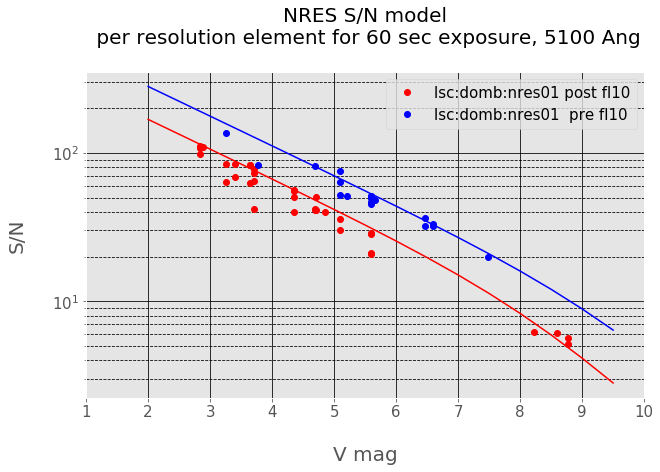

In [5]:

ron=5

fig, ax = plt.subplots(1)

plotfile ('nressn_postfl10.txt', color='red', label='lsc:domb:nres01 post fl10', refflux=180000)
plotfile ('nressn_prefl10.txt' , color='blue', label='lsc:domb:nres01  pre fl10', refflux=500000)

plt.legend(  fontsize=15)
plt.xlim([1,10])
plt.xlabel ( "\nV mag",  fontsize=20)
plt.ylabel ("S/N\n",  fontsize=20)
plt.title ("NRES S/N model\n per resolution element for 60 sec exposure, 5100 Ang\n",  fontsize=20)

ax.grid(b=True, which='major', color='k', linestyle='-')
ax.grid(b=True, which='minor', color='k', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=10)

plt.savefig("nressn_Sept2017.png");  